In [332]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [333]:
plt.rcParams['font.size'] = 14

In [334]:
import glob

In [335]:
folders = glob.glob("data/*")

In [336]:
folders

['data/teensy41_test_01',
 'data/pyboard_test_02',
 'data/pyboard_test_05_with_Arduino_isrPin',
 'data/pyboard_test_04_with_Arduino_isrPin',
 'data/pyboard_test_03_with_Arduino_isrPin',
 'data/teensy41_test_03',
 'data/teensy41_test_02',
 'data/pyboard_test_01',
 'data/teensy41_test_03_with_Arduino_isrPin']

## Note

- I made changes to reset the counter so that the test starts with a full time step beginning with `pyboard_test_05_with_Arduino_isrPin`

In [338]:
fn = "data/teensy41_test_03/digital.csv"

In [339]:
#fn = "data/pyboard_test_05_with_Arduino_isrPin/digital.csv"

In [340]:
import saleae

In [341]:
import importlib

In [342]:
importlib.reload(saleae)

<module 'saleae' from '/Users/kraussry/git/krauss_misc/saleae.py'>

In [343]:
mytest = saleae.saleae_csv(fn)

## Analysis Plan

- test really starts on first ch 0 edge after t=0
- squarewave on ch_0 keeps going after test is over


### Test 1

- what is the period between all edges on ch 0 after t=0?

## Beginning Plot

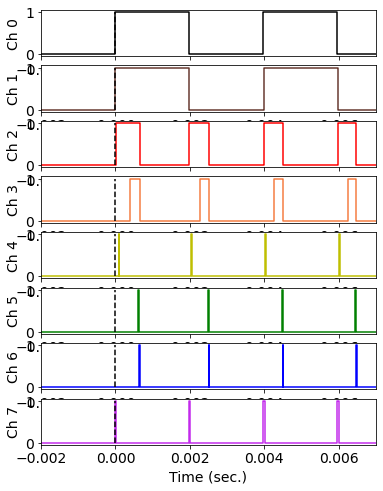

In [344]:
mytest.plot(xlim=[-0.002,0.007],cursor_x=0)

## Big Picture plot

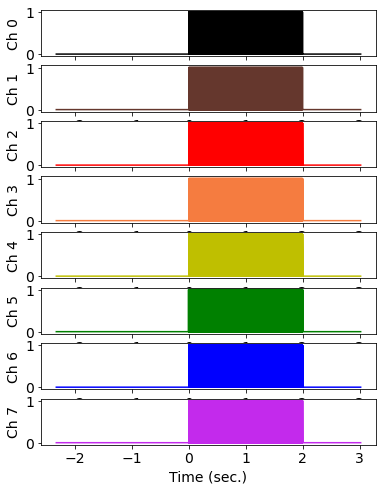

In [345]:
mytest.plot()

## Trying to find the end

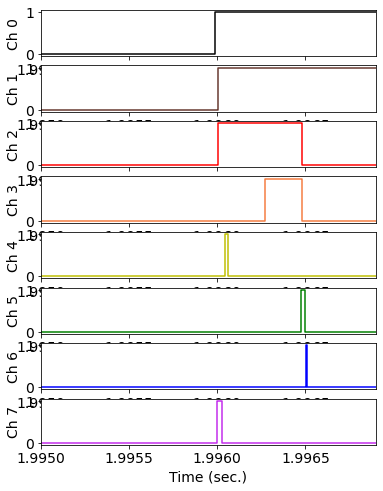

In [346]:
mytest.plot(xlim=[1.995,1.9969])

### Ending Note

- there are extra receiving and processing events related to turning the motor off
- the last falling edge on ch_3 is the end of the test for upython
- Arduino still needs to receive and process that last step's i2c transmission
- So, the test ends on the ch_6 falling edge after the last ch_3 falling edge

In [347]:
ch_3 = mytest.ch_3
ch_4 = mytest.ch_4
ch_5 = mytest.ch_5
ch_6 = mytest.ch_6

In [348]:
for i in range(8):
    cmd = "col_%i = mytest.columns[%i]" % (i,i)
    print(cmd)
    exec(cmd)

col_0 = mytest.columns[0]
col_1 = mytest.columns[1]
col_2 = mytest.columns[2]
col_3 = mytest.columns[3]
col_4 = mytest.columns[4]
col_5 = mytest.columns[5]
col_6 = mytest.columns[6]
col_7 = mytest.columns[7]


### Test End based on ch_3

In [349]:
t3_end = col_3.falling_edges[-1]
t3_end

1.99847768

### Test End based on ch_6

- find the next falling edge after `t3_end`

In [350]:
t6_falling = col_6.falling_edges

In [351]:
ind_6_end = np.where(t6_falling > t3_end)[0][0]
ind_6_end

999

In [352]:
t6_end = t6_falling[ind_6_end]
t6_end

1.99850236

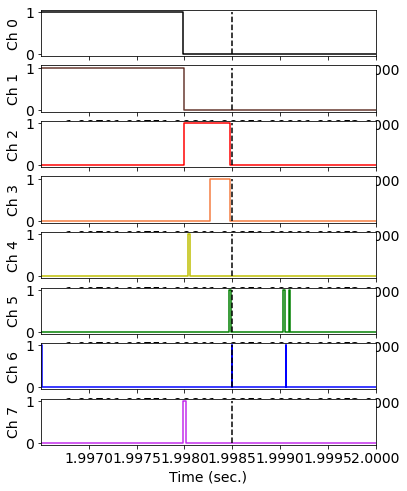

In [353]:
mytest.plot(xlim=[t6_end-0.002,t6_end+0.0015], cursor_x=t6_end)

In [354]:
col_0 = mytest.columns[0]

In [355]:
t_ISR = [t_i for t_i in col_0.change_edges if 0<= t_i < t6_end]
t_ISR = np.array(t_ISR)

In [356]:
t_ISR = np.append([0],t_ISR)

In [357]:
dt = t_ISR[1:] - t_ISR[0:-1]

In [358]:
t_ISR[1:6]

array([0.00196784, 0.00396504, 0.00595568, 0.00798112, 0.00994672])

In [359]:
t_ISR[0:5]

array([0.        , 0.00196784, 0.00396504, 0.00595568, 0.00798112])

In [360]:
t_ISR[1:6] - t_ISR[0:5]

array([0.00196784, 0.0019972 , 0.00199064, 0.00202544, 0.0019656 ])

In [361]:
dt[0:5]

array([0.00196784, 0.0019972 , 0.00199064, 0.00202544, 0.0019656 ])

In [362]:
dt.argmin()

4

In [363]:
dt.mean()

0.0019999819019019018

In [364]:
dt.max()

0.00202544

In [365]:
dt.min()

0.0019655999999999996

In [366]:
(dt.mean() - dt.min())*1e6

34.38190190190212

Text(0.5, 0, 'loop count')

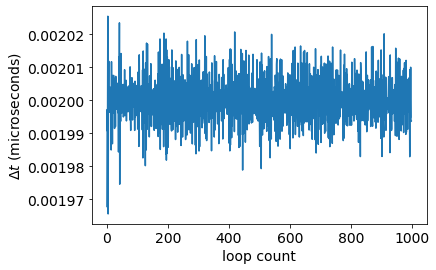

In [367]:
plt.figure()
plt.plot(dt)
plt.ylabel('$\\Delta t$ (microseconds)')
plt.xlabel('loop count')

Text(0.5, 0, 'loop count')

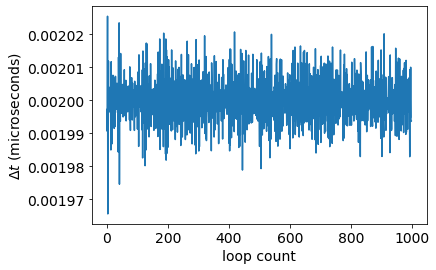

In [368]:
plt.figure()
plt.plot(dt[1:])
plt.ylabel('$\\Delta t$ (microseconds)')
plt.xlabel('loop count')

In [369]:
len(dt)

999

In [370]:
len(t_ISR)

1000

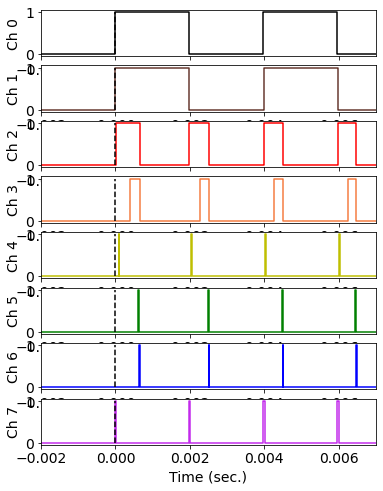

In [371]:
mytest.plot(xlim=[-0.002,0.007],cursor_x=t_ISR[0])

In [372]:
col_6.falling_edges

array([6.46400000e-04, 2.52192000e-03, 4.50552000e-03, ...,
       1.99650860e+00, 1.99850236e+00, 1.99906680e+00])

In [373]:
t_ISR[0:5]

array([0.        , 0.00196784, 0.00396504, 0.00595568, 0.00798112])

In [374]:
col_6.falling_edges[0:5]

array([0.0006464 , 0.00252192, 0.00450552, 0.0064828 , 0.00850284])

In [375]:
control_ISR_dt = col_6.falling_edges[0:-1] - t_ISR

Text(0.5, 0, 'Loop Count')

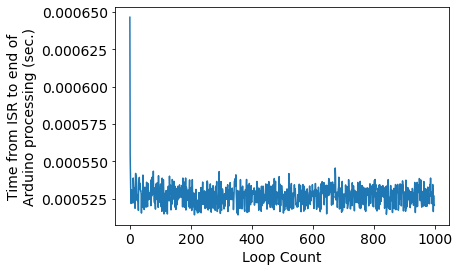

In [377]:
plt.figure()
plt.plot(control_ISR_dt)
plt.ylabel('Time from ISR to end of\nArduino processing (sec.)')
plt.xlabel('Loop Count')

In [378]:
bad_inds = np.where(control_ISR_dt > 0.002)[0]
bad_inds

array([], dtype=int64)

In [320]:
ind0 = np.where(mytest.t>0)[0][0]
ind0

54361

In [322]:
bad_inds_shifted = bad_inds + ind0
bad_inds_shifted

array([54556, 54753, 54950, 55147, 55344])

In [323]:
t_bad = mytest.t[bad_inds_shifted]
t_bad

array([0.02795188, 0.05596888, 0.08400648, 0.11201028, 0.14030412])

In [326]:
t_bad = col_6.falling_edges[bad_inds]
t_bad

array([0.39243572, 0.78639408, 1.18036588, 1.57435172, 1.96832444])

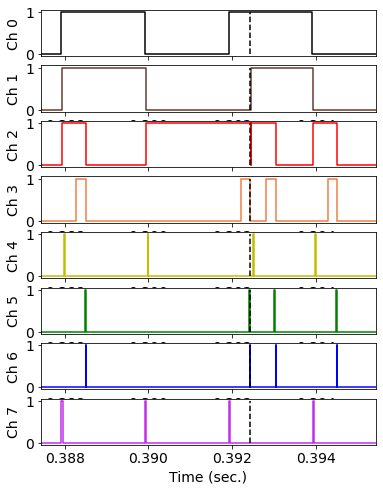

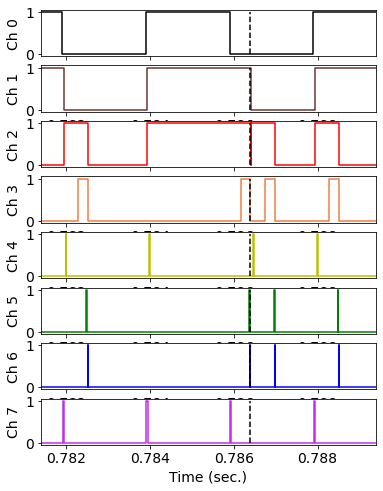

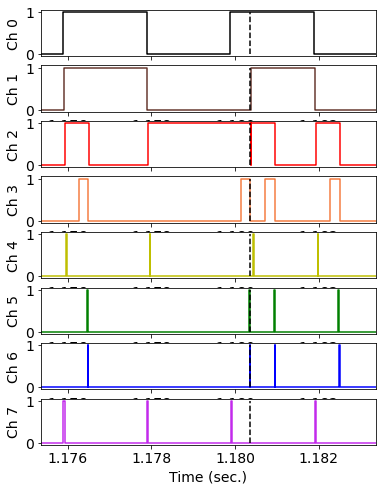

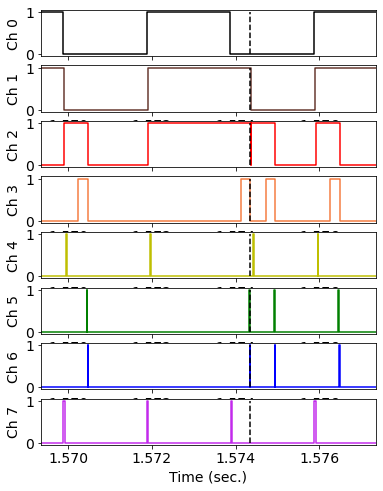

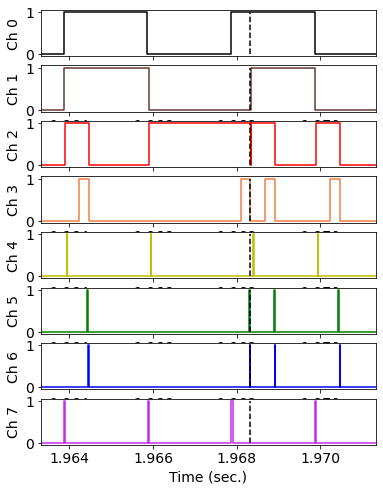

In [329]:
for tb in t_bad:
    mytest.plot(xlim=[tb-0.005,tb+0.003],cursor_x=tb)